In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
train_data = pd.read_csv("train.csv")
total_train_class = len(train_data.iloc[:, 1].drop_duplicates(ignore_index=True))
total_train_class

176

In [3]:
test_list = train_data.iloc[:,1].drop_duplicates(ignore_index=True).apply(lambda x: x.split("_")).to_list()
test_arry = np.array(test_list)
split_type = pd.DataFrame((test_arry[:, 0], test_arry[:, 1])).T

In [4]:
# split_type.drop_duplicates(subset=0)

In [5]:
# split_type.drop_duplicates(subset=1) # the class type is really the type

In [6]:
# conver type name to type number, use the list
class_name_list = train_data.iloc[:,1].drop_duplicates(ignore_index=True).to_list()

# self define the get_position function, hash map maybe fast, but the data is very small, just use iter compare
def get_position(target, list):
    for index, item in enumerate(list):

        if target == item:
            
            return index
    return len(list) # this indicate the new type called other

train_data.iloc[:, 1] = train_data.iloc[:, 1].apply(get_position, args=(class_name_list,))

In [7]:
# train_data

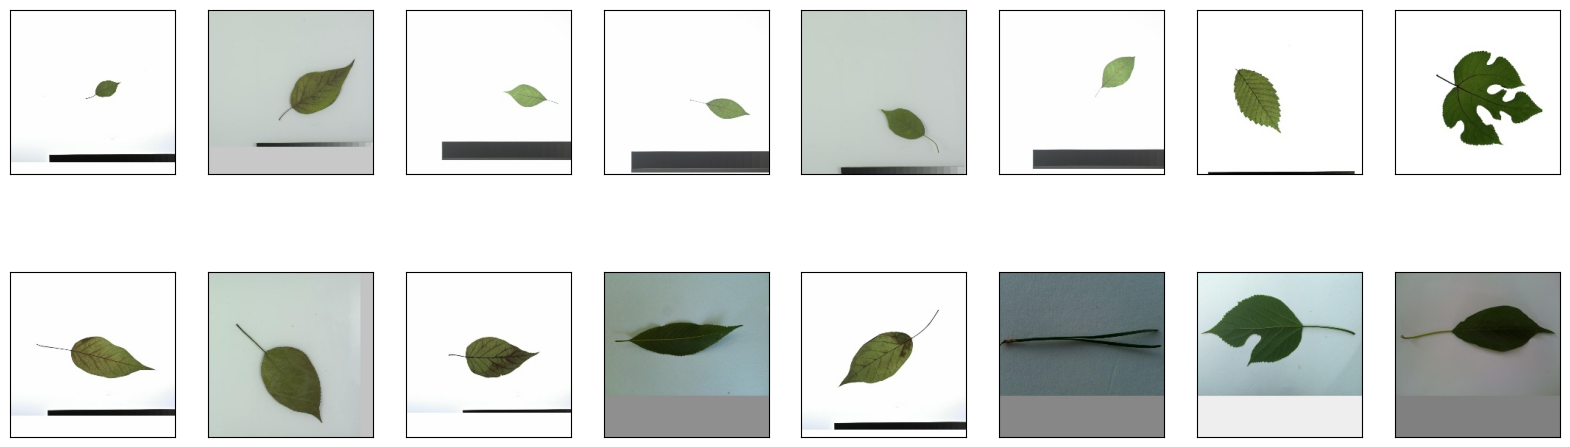

In [8]:
# check the same label data 

def plot_image(data_container, name_container, index, rows, columns):
    """print the image data from data_container
    """
    img_names = [name for name in data_container.iloc[index, 0].tolist()]
    imgs = [Image.open(img_name) for img_name in img_names]
    fig, axes = plt.subplots(rows, columns, figsize=(40/rows, 50/columns))
    axes = axes.flatten()
    plt.cla()
    for i, ax in enumerate(axes):
        ax.imshow(imgs[min(i, len(imgs)-1)])
        ax.set_xticks([])
        ax.set_yticks([])

plot_image(train_data, class_name_list, [i for i in range(200)], 2, 8)



In [9]:
class Leaves_Net(nn.Module):
    def __init__(self, num_of_class):
        super().__init__()
        # add the residual block
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1, stride=1), nn.ReLU(),
            nn.Conv2d(12, 20, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(20, affine=True) # 224 x 224 x 24
        )
        self.block1_res = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=1, stride=1) # the first layer
        )
        self.block1_pooling = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU())# 112 x 112 x 24
        # after stage 1, the shape is 112x112x24

        self.block2 = nn.Sequential(
            nn.Conv2d(20, 26, kernel_size=3, padding=1, stride=1), nn.ReLU(),
            nn.Conv2d(26, 32, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(32, affine=True)
        )
        self.block2_res = nn.Conv2d(20, 32, kernel_size=1, stride=1)  # just as before
        
        self.block2_pooling = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU())
        # after stage 2, the shape is 56x56x48

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 40, kernel_size=3, padding=1, stride=1), nn.ReLU(),
            nn.Conv2d(40, 48, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(48, affine=True), nn.ReLU()
        )
        self.block3_res = nn.Conv2d(32, 48, kernel_size=1, stride=1)  # just as before
        self.block3_pooling = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU()) 
        # after stage 3, the shape is 28x28x48

        # block4, no res
        self.block4 = nn.Sequential(nn.Conv2d(48, 56, kernel_size=5, stride=2), nn.ReLU(), # 11x11x72
                                    nn.Conv2d(56, 56, kernel_size=5, stride=1), nn.BatchNorm2d(56, affine=True), nn.ReLU()) # 8x8x72

        # reduce the final fully connected layer scale
        self.block5 = nn.Sequential(
            nn.Flatten(), nn.Linear(8*8*56, total_train_class), nn.Sigmoid()
        )

    def forward(self, X):
        X = self.block1(X) + self.block1_res(X)
        X = self.block1_pooling(X)
        X = self.block2(X) + self.block2_res(X)
        X = self.block2_pooling(X)
        X = self.block3(X) + self.block3_res(X)
        X = self.block3_pooling(X)
        X = self.block4(X)
        X = self.block5(X)
        return X

In [10]:
leaves_net = Leaves_Net(len(class_name_list))

In [11]:
class DataSet():
    def __init__(self, data_file, transforms=None, train=True, val_split=None):
        self.data_file = data_file
        self.transforms = transforms
        self.train = train
        self.val_split = val_split
        self.get_data_from_file()

    # self define the get_position function, hash map maybe fast, but the data is very small, just use iter compare
    def get_position(self, target, list):
        for index, item in enumerate(list):
            if target == item:
                return index
        return len(list) # this indicate the new type called other

    def get_data_from_file(self):
        """get the data from the specify data file
        """
        data_frame = pd.read_csv(self.data_file)
        # the test set don't have class
        if self.train:
            self.total_data_class = len(data_frame.iloc[:, 1].drop_duplicates(ignore_index=True)) # get the total class
            self.class_name_list = data_frame.iloc[:,1].drop_duplicates(ignore_index=True).to_list() # get the class name list
            data_frame.iloc[:, 1] = data_frame.iloc[:, 1].apply(self.get_position, args=(self.class_name_list,))
        self.data_frame = data_frame

    def __getitem__(self, index):
        img = Image.open(self.data_frame.iloc[index, 0])
        
        if self.transforms is not None:
            if not hasattr(self.transforms, "__len__"):
                transforms = [self.transforms]
            for transform in transforms:
                img = transform(img)
        if self.train:
            label = self.data_frame.iloc[index, 1]
            res = (img, label)
        else:
            res = (img, 0) # just for the dataloader
        return res

    def __len__(self):
        return len(self.data_frame)

In [12]:
def xavier_init(net):
    if type(net) == nn.Linear or type(net) == nn.Conv2d:
        nn.init.xavier_uniform_(net.weight)

In [13]:
def get_device():
    if torch.cuda.is_available():
        device = "cuda:0"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
        
    return torch.device(device)

device = get_device()
device

device(type='cuda', index=0)

In [14]:
def accuracy(predict, targets):
    return (predict.argmax(axis=1) == targets).sum()

In [15]:
train_data = DataSet("train.csv", torchvision.transforms.ToTensor())
test_data = DataSet("test.csv", torchvision.transforms.ToTensor(), train=False)

# set the hypeter paramters including the batch_size 
batch_size = 24
epochs = 80
lr = 0.1


train_set, test_set= torch.utils.data.random_split(train_data, [0.8, 0.2])
train_loader, test_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True), DataLoader(test_set, batch_size=batch_size, shuffle=True)

num_batches = len(train_set) // batch_size
 
# for data in train_loader : 
#     imgs, targets = data
#     print(imgs.shape)
#     print(targets)
#     break

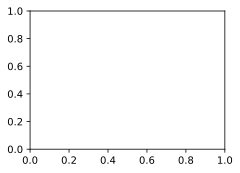

In [16]:
# define the loss function and optmizer
loss_fn = nn.CrossEntropyLoss().to(device)

updater = torch.optim.SGD(leaves_net.parameters(), lr=lr)

leaves_net.apply(xavier_init) # initialize the parameters
leaves_net.to(device)

# use d2l acc and animator
metrics = d2l.Accumulator(4)
animator = d2l.Animator(xlim=(1, epochs), ylim=(0, 5), legend=["train_loss", "train_acc", "test_loss", "test_acc"])

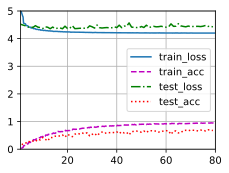

In [17]:
for epoch in range(epochs):
    leaves_net.train()
    metrics.reset()
    for i, (imgs, targets) in enumerate(train_loader):
        imgs, targets = imgs.to(device), targets.to(device)
        output = leaves_net(imgs)
        tmp_loss = loss_fn(output, targets)
        updater.zero_grad()
        tmp_loss.backward()
        before = list(leaves_net.parameters())[0].clone()
        updater.step()
        acc = accuracy(output, targets)
        metrics.add(tmp_loss, acc, len(targets), 1)
        
        after = list(leaves_net.parameters())[0].clone()
        if (i+1) % (num_batches // 5) == 0 or (i == num_batches - 1):
            animator.add(epoch+1+i/num_batches, (metrics[0]/metrics[-1], metrics[1] / metrics[2],None, None))
        grad_update = torch.sum(after - before)

    leaves_net.eval()
    metrics = d2l.Accumulator(4)

    with torch.no_grad():
        for (imgs, targets) in test_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            output = leaves_net(imgs)
            tmp_loss = loss_fn(output, targets)
            acc = accuracy(output, targets)
            metrics.add(tmp_loss, acc, len(targets), 1)
        animator.add(epoch, (None, None, metrics[0]/metrics[-1], metrics[1] / metrics[2]))



In [18]:
device

device(type='cuda', index=0)

In [19]:
torch.save(leaves_net.state_dict(), "leaves7.params")

In [20]:
# use leaves1 to predict 
test_loader = DataLoader(test_data, batch_size=batch_size)
result = []
leaves_net.eval()
with torch.no_grad():
    for (imgs, _) in test_loader:
        imgs = imgs.to(device)
        output = leaves_net(imgs)
        result.extend(output.argmax(axis=-1))

In [21]:
result_name = [class_name_list[i] for i in result]
result_name

['asimina_triloba',
 'zelkova_serrata',
 'liquidambar_styraciflua',
 'pinus_bungeana',
 'platanus_acerifolia',
 'koelreuteria_paniculata',
 'magnolia_stellata',
 'metasequoia_glyptostroboides',
 'betula_jacqemontii',
 'amelanchier_arborea',
 'quercus_montana',
 'prunus_sargentii',
 'magnolia_denudata',
 'castanea_dentata',
 'pinus_echinata',
 'metasequoia_glyptostroboides',
 'picea_pungens',
 'quercus_michauxii',
 'pinus_cembra',
 'cryptomeria_japonica',
 'quercus_palustris',
 'ginkgo_biloba',
 'cercis_canadensis',
 'ptelea_trifoliata',
 'halesia_tetraptera',
 'liriodendron_tulipifera',
 'acer_rubrum',
 'pinus_resinosa',
 'quercus_montana',
 'carpinus_betulus',
 'magnolia_acuminata',
 'tilia_tomentosa',
 'carya_glabra',
 'quercus_palustris',
 'prunus_virginiana',
 'cornus_florida',
 'magnolia_macrophylla',
 'acer_palmatum',
 'picea_pungens',
 'abies_concolor',
 'zelkova_serrata',
 'liriodendron_tulipifera',
 'stewartia_pseudocamellia',
 'pinus_pungens',
 'gleditsia_triacanthos',
 'corn

In [22]:
test_frame = pd.read_csv("test.csv")
test_frame["label"] = pd.Series(result_name, index=test_frame.index)
test_frame.to_csv("submission7.csv", index=False)